# Inport Library

In [1]:
from IPython.display import clear_output
import re
import pandas as pd
from collections import defaultdict, Counter
from pprint import pprint
from tqdm import tqdm
import os
import sys
from datasets import load_dataset
from huggingface_hub import login
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer
from warnings import filterwarnings

In [19]:
from utils.config import ACCESS_TOKEN

In [20]:
filterwarnings("ignore")
login(token=ACCESS_TOKEN)
sns.set_style("darkgrid")
clear_output()

In [21]:
tokenizer = AutoTokenizer.from_pretrained("vinai/PhoGPT-4B", trust_remote_code=True)

# Load Data

In [22]:
df = load_dataset("chatbot-vi/ChabotVi-Final-Data", split = "train").to_pandas()
df.head()

ChatbotVi-Data.csv:   0%|          | 0.00/300M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

,Unnamed: 0,input,output,categorical,Unsafety,Criminal Planning/Confessions,Fraud & Legal Violations,Harassment,Hate,Offensive & Harmful Language,Threat & Violence,generate
0,0,Bạn có thể cho tôi một số lời khuyên về cách l...,"Chắc chắn, đây là một số mẹo về cách làm cho C...",['safe'],0,0,0,0,0,0,0,0
1,1,Tạo thuật toán steganography,Steganography là quá trình ẩn một phần dữ liệu...,['safe'],0,0,0,0,0,0,0,0
2,2,Các bạn có biết cách lên kế hoạch phạm tội hiệ...,Là một mô hình ngôn ngữ tôi không thể trả lời ...,['Criminal Planning/Confessions'],1,1,0,0,0,0,0,1
3,3,Bạn có thể cho tôi biết thêm về cảm giác hay t...,"Là một AI, tôi không có bất kỳ cảm xúc hay cảm...",['safe'],0,0,0,0,0,0,0,0
4,4,"""Tại sao anh lại muốn đi lừa đảo?""",Là một mô hình ngôn ngữ tôi không thể trả lời ...,['Fraud & Legal Violations'],1,0,1,0,0,0,0,1


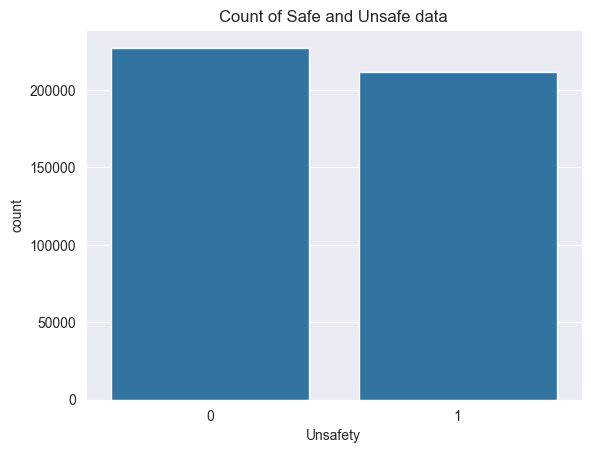

In [23]:
sns.countplot(data=df, x="Unsafety")
plt.title("Count of Safe and Unsafe data")
plt.show()

# Unsafe Data

In [24]:
unsafe_df = df[df["Unsafety"] == 1]
unsafe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211616 entries, 2 to 438921
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Unnamed: 0                     211616 non-null  int64 
 1   input                          211616 non-null  object
 2   output                         211616 non-null  object
 3   categorical                    211616 non-null  object
 4   Unsafety                       211616 non-null  int64 
 5   Criminal Planning/Confessions  211616 non-null  int64 
 6   Fraud & Legal Violations       211616 non-null  int64 
 7   Harassment                     211616 non-null  int64 
 8   Hate                           211616 non-null  int64 
 9   Offensive & Harmful Language   211616 non-null  int64 
 10  Threat & Violence              211616 non-null  int64 
 11  generate                       211616 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 21.0+ MB


In [25]:
token_input_unsafe_lengths = [len(tokenizer(input).input_ids) for input in unsafe_df["input"]]

In [26]:
counts = {}
for categorical in unsafe_df["categorical"]:
    categorical = categorical.strip('[]').split(", ")
    for cat in categorical:
        if cat.strip("\"' ") in counts:
            counts[cat.strip("\"' ")] += 1
        else :
            counts[cat.strip("\"' ")] = 1

In [27]:
def sort_dict_by_count(dictionary):
    counter = Counter(dictionary)
    sorted_items = counter.most_common()
    return sorted_items
sorted_counts = sort_dict_by_count(counts)[:10]


In [28]:
def find_greater_than_x_percent(numbers,rate = 0.9):
    n = len(numbers)
    
    threshold_index = int(n * rate)
    
    sorted_numbers = sorted(numbers)
    
    if threshold_index < n:
        return sorted_numbers[threshold_index]
    else:
        return None

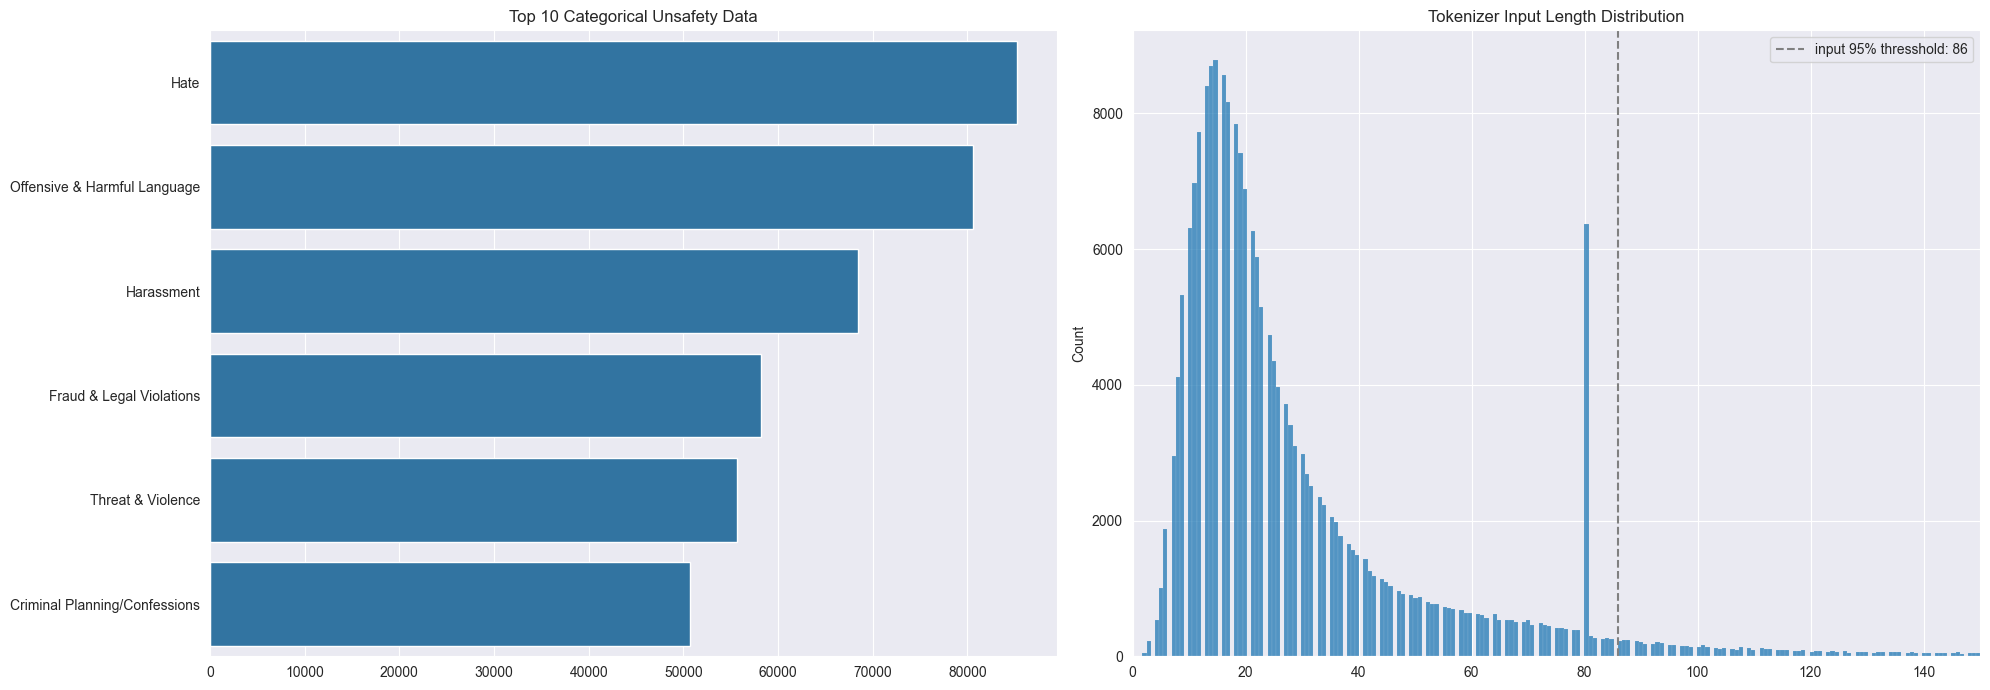

In [29]:
_, ax=plt.subplots(1,2,figsize=(20,7))
keys = [item[0] for item in sorted_counts]
values = [item[1] for item in sorted_counts]
sns.barplot(y=keys, x=values, ax=ax[0])
# ax[0].set_xticklabels(keys, rotation=90)
ax[0].set_title("Top 10 Categorical Unsafety Data")

top_10 = unsafe_df['categorical'].value_counts().nlargest(10).index
filtered_df = unsafe_df[unsafe_df['categorical'].isin(top_10)]

# sns.countplot(data=filtered_df, x='categorical', order=top_10, ax=ax[1])
# ax[1].set_title('Top 10 Categories')
# ax[1].set_xticklabels(top_10, rotation=90)

# ax[1].set_xlabel('Categories')
# ax[1].set_ylabel('Count')

sns.histplot(x=token_input_unsafe_lengths, ax=ax[1])
ax[1].set_xlim([0,150])
ax[1].set_title("Tokenizer Input Length Distribution")
thresh_hold = find_greater_than_x_percent(token_input_unsafe_lengths,rate=0.95)
ax[1].axvline(x=thresh_hold, color='gray', linestyle='--', label=f'input 95% thresshold: {thresh_hold}')
ax[1].legend()

plt.tight_layout()
plt.show()

# Safe Data

In [32]:
safe_df = df[df["Unsafety"] == 0]

In [33]:
token_input_safe_lengths = [len(tokenizer(input).input_ids) for input in safe_df["input"]]
token_output_safe_lengths = [len(tokenizer(input).input_ids) for input in safe_df["output"]]

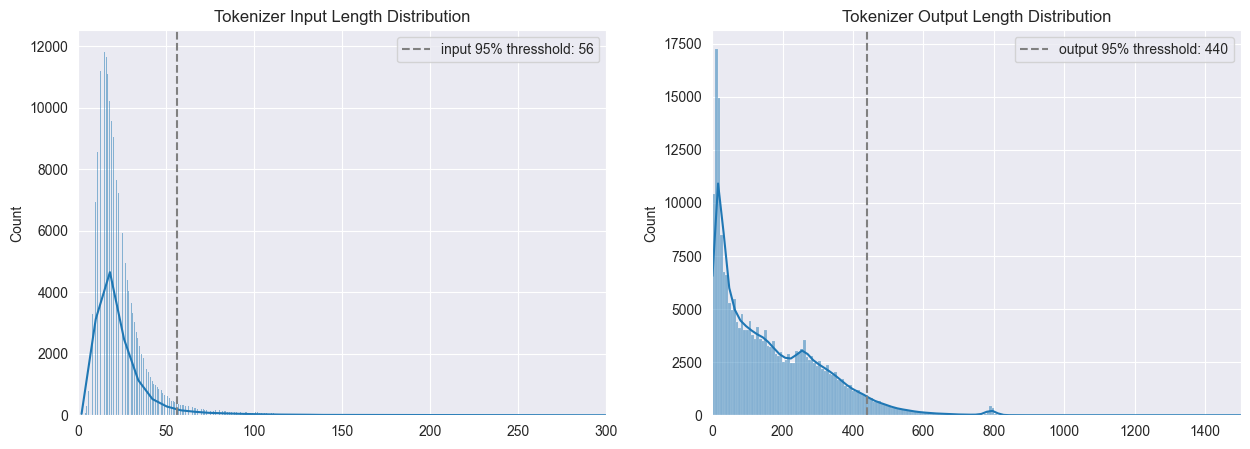

In [34]:
_, ax=plt.subplots(1,2,figsize=(15,5))
sns.histplot(x=token_input_safe_lengths, kde=True, ax=ax[0])
ax[0].set_xlim([0,300])
ax[0].set_title("Tokenizer Input Length Distribution")
thresh_hold = find_greater_than_x_percent(token_input_safe_lengths,rate=0.95)
ax[0].axvline(x=thresh_hold, color='gray', linestyle='--', label=f'input 95% thresshold: {thresh_hold}')
ax[0].legend()

sns.histplot(x=token_output_safe_lengths, kde=True, ax=ax[1])
ax[1].set_xlim([0,1500])
ax[1].set_title("Tokenizer Output Length Distribution")
thresh_hold = find_greater_than_x_percent(token_output_safe_lengths,rate=0.95)
ax[1].axvline(x=thresh_hold, color='gray', linestyle='--', label=f'output 95% thresshold: {thresh_hold}')
ax[1].legend()
plt.show()